In [1]:
import numpy as np
import tensorflow as tf
import sunpy.map
import os
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop

import datetime
import time

import matplotlib.pyplot as plt
import IPython.display as display

import flares as fl
import data_prep as prep

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # 这一行注释掉就是使用gpu，不注释就是使用cpu

### The Layout of the program

The basic layout of the program is as such:
First getting a index dataset as a index of all fits data, since there is not enough memory to read all data at once. Then complile all the necessary functions and initialize the neural networks. Finally it reads data in batches and trains. So the main function is only at the beginning and the end of this notebook. Middle parts are all function definitions. This should make this program less messy than it seems.

In [3]:
# SET
PATH = r'E:\Program Files\VSCode\2021_ImagingWithDeepLearning\my_test_data_8'
output_path = r'E:\Program Files\VSCode\2021_ImagingWithDeepLearning\output_12'
if not os.path.exists(output_path):
    os.makedirs(output_path)

INPUT_CHANNELS = 9
OUTPUT_CHANNELS = 1
INPUT_SHAPE = [512, 512, INPUT_CHANNELS]
OUTPUT_SHAPE = [512, 512, 1]
Scaler_aia = Rescaling(scale=1.0 / 64000)
Scaler_lya = Rescaling(scale=1.0 / 10000)
Scaler_hmi = Rescaling(scale=1.0 / 76000)
# Scaler_aia = Rescaling(scale=1.0) # Try
# Scaler_lya = Rescaling(scale=1.0)
# Scaler_hmi = Rescaling(scale=1.0)
Cropper = CenterCrop(height=512, width=512)

RAND_BUFFER_SIZE = 1000
INDEX_BATCH_SIZE = 10
TRAIN_SET_SIZE = 52 # 决定前多少个dataset是train的，后面的是test的
REPEAT = 2 # 决定将已有数据重复多少遍，并加random jitter以充分利用数据
# 注意每个batch是REPEAT * INDEX_BATCH_SIZE个数据

LAMBDA = 100

# Flip or not with HMI data. Depends on what your data look like.
flip = True

## Data Loading and Prep

Load data from fits files, apply normalization to 0~1 and random jittering.

### Define Random Jitter

In [4]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image
  
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, 512, 512, INPUT_CHANNELS])

  return cropped_image[0], cropped_image[1]
  
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing
  input_image, real_image = resize(input_image, real_image, 600, 600)

  # Random cropping back
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

### Load Data!!!

Let's dance.

In [5]:
# Make a multi-channels dataset
dataset_fits_list = []
for i in range(INPUT_CHANNELS + 1): # Walk all directories
    path = os.path.join(PATH, str(i))
    fits_list = fl.get_fits_list(path)
    dataset_fits_list.append(fits_list)


In [6]:
dataset_fits_list = np.array(dataset_fits_list)
dataset_fits_list = np.array(list(zip(*dataset_fits_list))) # 将其横向组合

In [7]:
index_dataset = tf.data.Dataset.from_tensor_slices(dataset_fits_list)
# 分开train和test dataset
index_train_dataset = index_dataset.take(TRAIN_SET_SIZE)
index_test_dataset = index_dataset.skip(TRAIN_SET_SIZE)
# Shuffle and batch up
index_train_dataset = index_train_dataset.shuffle(RAND_BUFFER_SIZE)
index_train_dataset = index_train_dataset.batch(INDEX_BATCH_SIZE)
index_test_dataset = index_test_dataset.batch(100) # Just to have access with 'for'

In [8]:
def get_dataset(dataset_fits_list): # new
    """Generate dataset from a fits list. The list is like:
    [
    [output_dir//0//xxxx.fits, output_dir//1//xxxx.fit, ...]
    [output_dir//0//xxxx.fits, output_dir//1//xxxx.fit, ...]
    [output_dir//0//xxxx.fits, output_dir//1//xxxx.fit, ...]
    ...
    [output_dir//0//xxxx.fits, output_dir//1//xxxx.fit, ...]
    ]
    """
    examples = []
    labels = []
    for set in dataset_fits_list:
        all_channels = []
        for fits in set:
            fits = fits.numpy().decode() # fits 
            telescope = prep.TelescopeFits(fits)
            if 'AIA' in telescope:
                data = prep.AIAPrep(fits, Scaler_aia, Cropper)
            elif 'VAULT' in telescope:
                data = prep.VAULTPrep(fits, Scaler_lya, Cropper)
            elif 'HMI' in telescope:
                data = prep.HMIPrep(fits, Scaler_hmi, Cropper, flip=True) 
            all_channels.append(data)

        input_channel = tf.concat(all_channels[:-1], axis=2)
        examples.append(input_channel)

        zeros = tf.zeros([512, 512, INPUT_CHANNELS - 1])
        output_channel = tf.concat([all_channels[-1], zeros], axis=2)
        labels.append(output_channel)
    
    dataset = tf.data.Dataset.from_tensor_slices((examples, labels))

    return dataset

### Prepare train and test dataset!

In [9]:
def extract_dim(input_image, real_image):
    unstacked = tf.unstack(real_image, axis=2)
    real_image = unstacked[0]
    real_image = tf.expand_dims(real_image, 2)
    return input_image, real_image

In [10]:
def prep_train_dataset(dataset):
    # Repeat and apply random jitter to make more use of limited data.
    train_dataset = dataset.repeat(REPEAT)
    train_dataset = train_dataset.map(random_jitter)

    # Eliminate redundant channels in output images
    train_dataset = train_dataset.map(extract_dim)

    # Separate into batches
    train_dataset = train_dataset.batch(1)

    return train_dataset

## Construct(Define) the Generator, Discriminator, Loss Function, Fit Function and Checkpoint

In [11]:
def downsample(filters, size, apply_batchnorm=True, use_ReLU=False, use_Sigmoid=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  if use_ReLU:
    result.add(tf.keras.layers.ReLU())
  elif use_Sigmoid:
    result.add(tf.keras.layers.Activation('sigmoid'))
  else:
    result.add(tf.keras.layers.LeakyReLU(alpha=0.2))

  return result

def upsample(filters, size, apply_dropout=False, use_Tanh=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  if not use_Tanh:
    result.add(tf.keras.layers.ReLU())
  else:
    result.add(tf.keras.layers.Activation('tanh'))
  

  return result
  
def Generator():
  inputs = tf.keras.layers.Input(shape=INPUT_SHAPE)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # 64 convolution kernels with size 4*4
    downsample(128, 4),  # 128 convolution kernels with size 4*4
    downsample(256, 4),  
    downsample(512, 4),  
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4),
    downsample(512, 4, use_ReLU=True),
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4), 
    upsample(256, 4),  
    upsample(128, 4),  
    upsample(64, 4),
    upsample(1, 4, use_Tanh=True),
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [12]:
generator = Generator()
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  # Max absolute error -maybe suitable for bright region
  linf_loss = tf.abs(tf.reduce_max(target) - tf.reduce_max(gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss
  
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=INPUT_SHAPE, name='input_image')
  tar = tf.keras.layers.Input(shape=OUTPUT_SHAPE, name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 512, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [14]:
discriminator = Discriminator()

In [15]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)# Originally 2e-4
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [18]:
def generate_images(model, test_input, tar, save=True):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 12))

  input_images = tf.unstack(test_input[0], axis=2)
  input_images.append(tar[0])
  input_images.append(prediction[0])
  display_list = input_images # unstack input. Not sure if this could work.
  title = ['Input Image(s)', 'Ground Truth', 'Predicted Image']

  for i in range(INPUT_CHANNELS + 2):
    plt.subplot(3, 4, i+1)# 3*4, 11 images in total
    if i < INPUT_CHANNELS:
      plt.title(title[0])
    else:
      plt.title(title[i - INPUT_CHANNELS + 1])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')

  if save:
    time_now = datetime.datetime.now().strftime('%Y%m%dT%H%M%S')
    full_file = os.path.join(output_path, 'output' + time_now + '.jpg')
    plt.savefig(full_file)
  
  plt.show()

In [19]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [20]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
    tf.summary.scalar('disc_loss', disc_loss, step=step) # 原step//1000
    
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 500 == 0:
      display.clear_output(wait=True)

      generate_images(generator, example_input, example_target)

      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

## Construction Visualization

Our Generator is constructed in a U shaped manner, with 14 + 7 layers. 14 convolution layes, 7 concatenate layers. 

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

## Load TensorBoard and Start Training

In [ ]:
%load_ext tensorboard

In [21]:
# Get test dataset
for batch_fits_list in index_test_dataset:
    test_dataset = get_dataset(batch_fits_list)
    test_dataset = test_dataset.map(extract_dim)
    test_dataset = test_dataset.batch(1)
    break

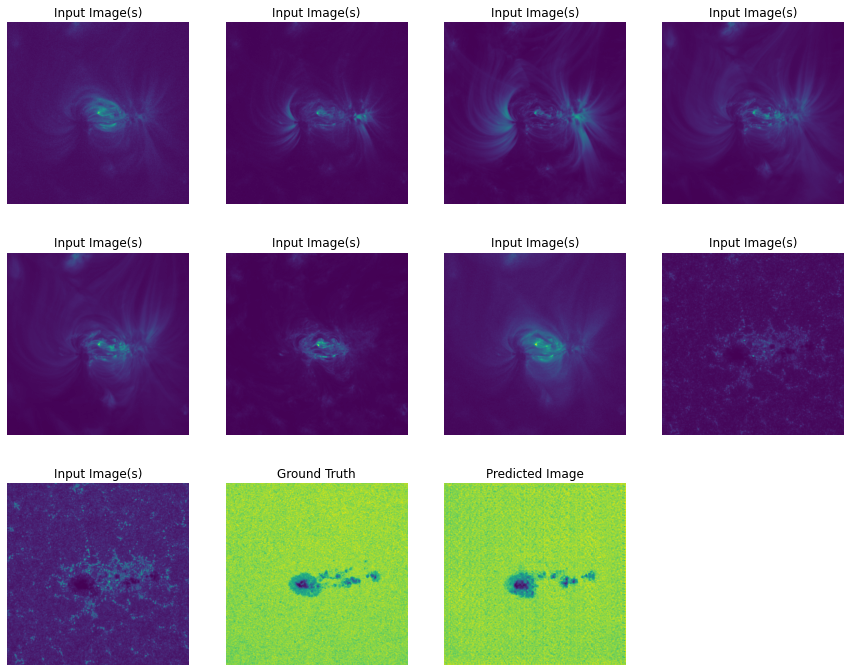

Step: 3k
..................................................

In [22]:
# Get train dataset and train
for batch_fits_list in index_train_dataset:
    train_dataset = get_dataset(batch_fits_list)
    train_dataset = prep_train_dataset(train_dataset)
    fit(train_dataset, test_dataset, steps=4000)
    # break # For test, run only one loop

In [27]:
# Save
checkpoint.save(file_prefix=checkpoint_prefix)

'./training_checkpoints\\ckpt-1'

## Recap and Test

In [26]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# Run the trained model on a few examples from the train set
for inp, tar in train_dataset.take(20):
    generate_images(generator, inp, tar, save=False)

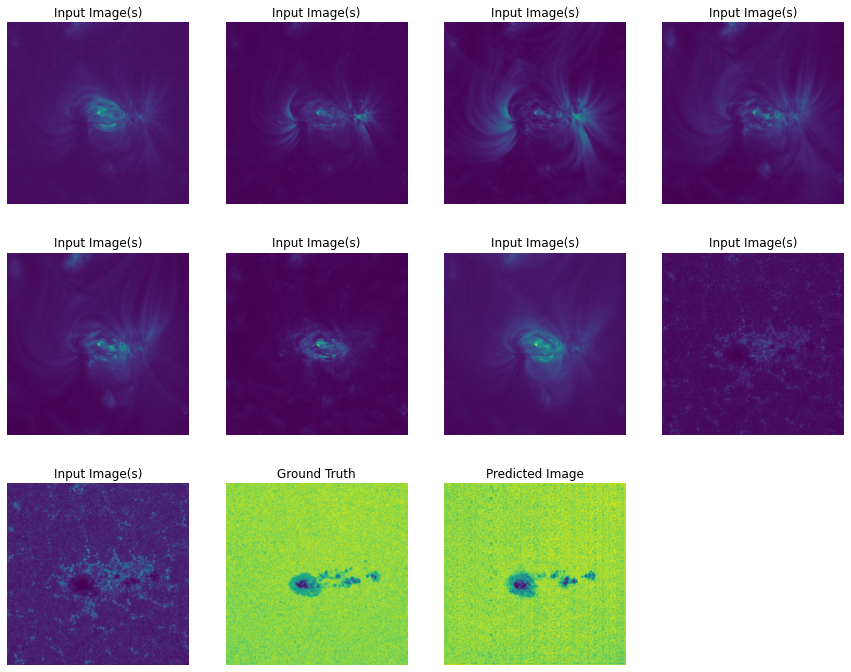

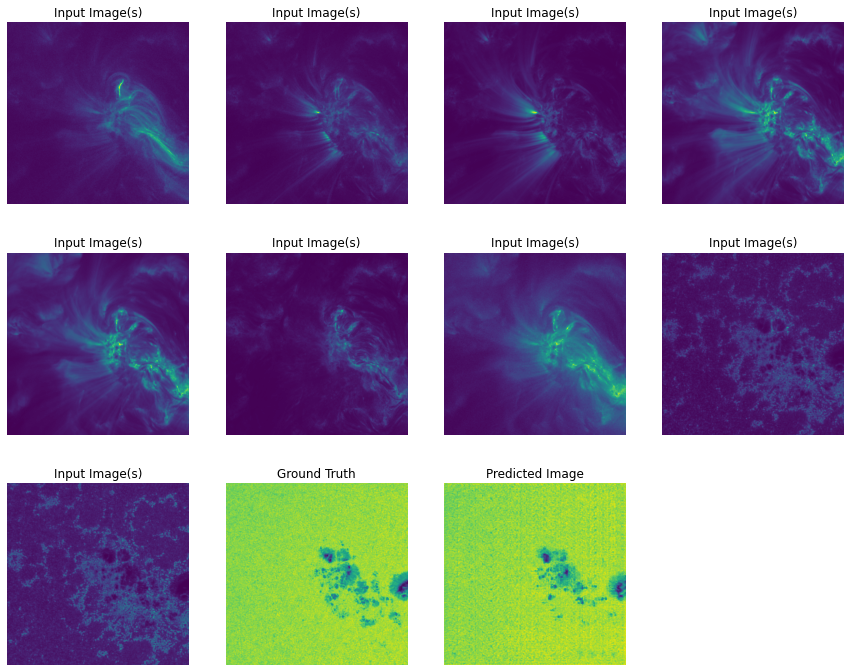

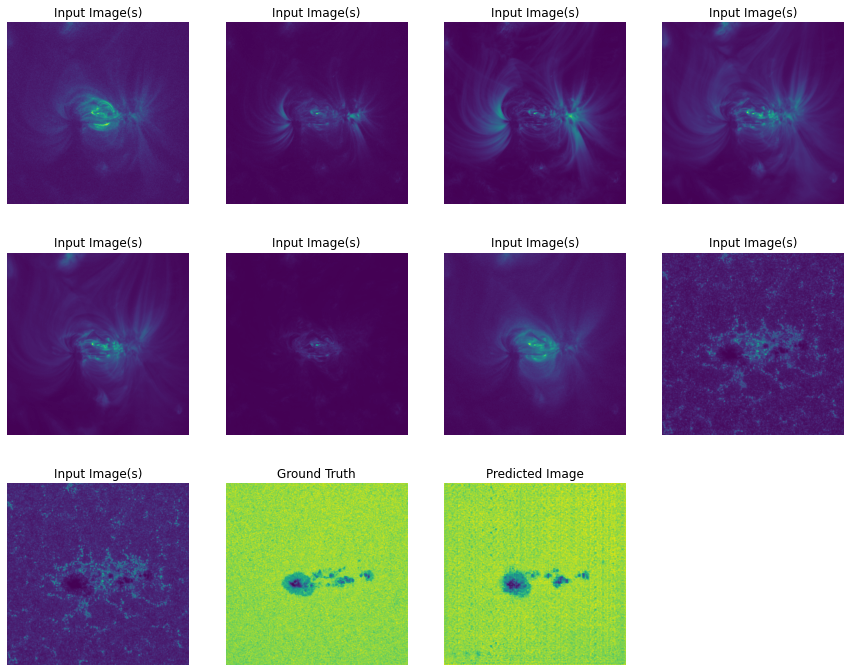

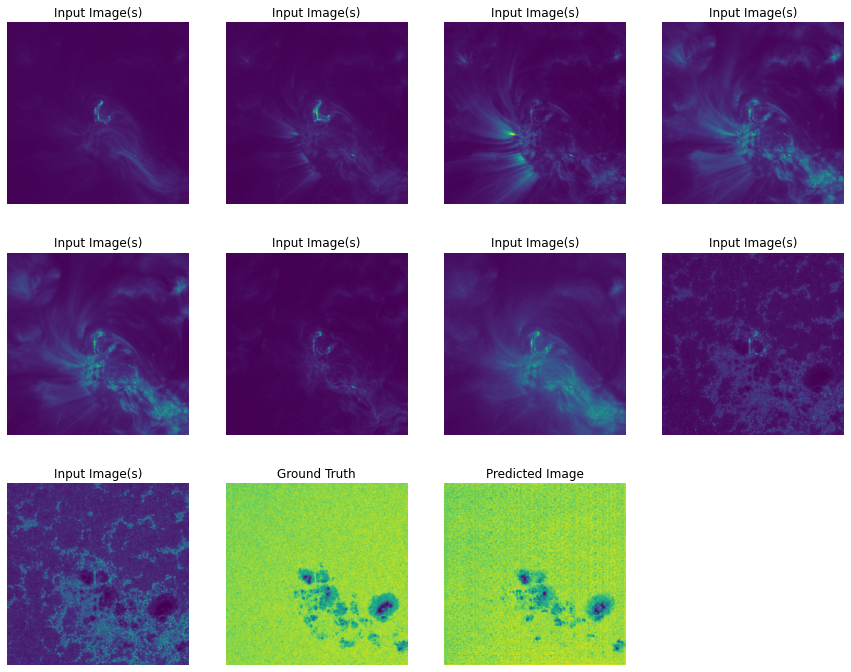

In [28]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(10):
    generate_images(generator, inp, tar, save=False)

In [ ]:
# Run the trained model on a few examples from the validation set
for inp, tar in val_dataset.take(10):
    generate_images(generator, inp, tar, save=False)